In [2]:
import cv2
import numpy as np
import os
import math as m
import re
import pandas as pd
import scipy
from scipy.stats import skew
from scipy.stats import kurtosis
import mahotas
from skimage.feature import local_binary_pattern
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
polygons = {}

In [1]:

def gauss(vertices):
    n = len(vertices)
    area = 0.0

    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        area += x1 * y2 - x2 * y1

    area = abs(area) / 2

    return area

def perimeter_calc(vertices):
    n = len(vertices)

    perimeter = 0.0

    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        perimeter += m.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return perimeter

def calculate_roundness(vertices):
    area = gauss(vertices)
    perimeter = perimeter_calc(vertices)

    roundness = 4 * m.pi * area / perimeter ** 2

    return "{:.4f}".format(roundness)

def compute_color_moments(vertices, img):

    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)

    #polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    masked_image = cv2.bitwise_and(img, mask)
    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    average_color = cv2.mean(masked_image, mask=gray_mask)
    #BGRg
    #blue green red (gray/neutral)

    std_dev = np.std(masked_image)
    skewnessval = scipy.stats.skew(masked_image.flatten())
    kurt = kurtosis(masked_image.flatten())



    #print("Average color:", average_color)
    #print("std dev", std_dev)
    #print("skewness", skewnessval)
    #print("kurtosis", kurt)


    return average_color, std_dev, skewnessval, kurt
    ####

    '''
    
    imagepoly = img.copy()
    average_mask = img.copy()


    cv2.polylines(imagepoly, [polygon], True, (0, 255, 0), thickness=2)

    cv2.fillPoly(average_mask, [polygon], average_color)

    horizontal1 = np.hstack((img, imagepoly))
    horizontal2 = np.hstack((masked_image, average_mask))

    vertical = np.vstack((horizontal1, horizontal2))

    

    cv2.imshow("Image", vertical)



    cv2.waitKey(0)
    cv2.destroyAllWindows()

    '''



def compute_Zernike(vertices, img):
    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    
    masked_image = cv2.bitwise_and(img, mask)

    gray_mask = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    zernike_moments = mahotas.features.zernike(gray_mask, radius=100, degree=8, cm=(100, 100))
    return zernike_moments.tolist()

def compute_LBP(vertices, img):
    #local binary patterns for texture
    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    
    masked_image = cv2.bitwise_and(img, mask)

    gray_mask = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    lbp = local_binary_pattern(gray_mask, P=8, R=1, method='uniform')

    hist, _ = np.histogram(lbp, bins=np.arange(0, 11), density=True)

    #print("LBP Histogram:", hist)
    return hist.tolist()

def compute_HUMoments(vertices, img):
    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    
    masked_image = cv2.bitwise_and(img, mask)

    gray_mask = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    moments = cv2.moments(gray_mask)

    hu_moments = cv2.HuMoments(moments).flatten()

    #print("Hu Moments:", hu_moments)
    for i in range(0,7):
        hu_moments[i] = -1* m.copysign(1.0, hu_moments[i]) * m.log10(abs(hu_moments[i]))

    
    return hu_moments.tolist()

def get_square(vertices, img):
    maxx = -1
    maxy = -1
    minx = 99999
    miny = 99999
    for v in vertices:
        maxx = max(maxx, v[0])
        maxy = max(maxy, v[1])
        minx = min(minx, v[0])
        miny = min(miny, v[1])

    p1 = [minx, miny]
    p2 = [maxx, miny]
    p3 = [maxx, maxy]
    p4 = [minx, maxy]

    return np.asarray([p1, p2, p3, p4]), img[miny:maxy, minx:maxx]

    


# Retrieving features

This section receives the directory of the images and a directory containing the polygons that describe the form of each fruit

In [4]:
import cv2
import numpy as np
import os
import re
#"/Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images"
image_dir = "/Users/pablo/Documents/Programacion/StrawberriesImageMassDataset/Strawberries.v1i.yolov8/train/images"
annotation_dir = "/Users/pablo/Documents/Programacion/StrawberriesImageMassDataset/Strawberries.v1i.yolov8/train/labels"


regexpattern = r"strawberry(\d+)"

for image_file in os.listdir(image_dir):
    #print(image_file)
    if image_file.endswith(".jpg"):

        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        #print(image.shape)
  
        #print(image_file)
        annotation_file = os.path.splitext(image_file)[0] + ".txt"
        imageID = re.search(regexpattern, annotation_file).group(0)[10:]

        #print(imageID)
        #print(annotation_file)

        annotation_path = os.path.join(annotation_dir, annotation_file)
        #print(annotation_path)
        with open(annotation_path, "r") as f:
            annotations = f.readlines()
            #print(annotations)

        for annotation in annotations:
            # Split the annotation into its components
            components = annotation.split()
            class_id = int(components[0])
            coords = []

            for i in range(1, len(components)):
                corrected = 0
                if(i%2 == 0):
                    corrected = float(components[i]) * image.shape[0] 
                else:
                    corrected = float(components[i]) * image.shape[1]
                coords.append(corrected)

            points = np.array(coords).reshape((-1, 2)).astype(np.int32)
            #print(points)
            #print(gauss(points))

            mean, stddev, skewnessval, kurt = compute_color_moments(points.tolist(), image)

            humoments = compute_HUMoments(points.tolist(), image)

            square, croppedimg = get_square(points.tolist(), image)

            zernike = compute_Zernike(points.tolist(), image)

            localBinaryPatterns = compute_LBP(points.tolist(), image)
            
            #print(mean, stddev, skewnessval, kurt, humoments, zernike)
            polygons[imageID] = {"coordinates" : points.tolist(), 
                                 "area" : gauss(points), 
                                 "roundness" : calculate_roundness(points), 
                                 "meancolor" : mean,
                                 "meanB" : mean[0],
                                 "meanG" : mean[1],
                                 "meanR" : mean[2],
                                 "meangray" : mean[3],

                                 "stddev" : stddev,
                                 "skewness" : skewnessval,
                                 "kurtosis" : kurt,
                                 "h0" : humoments[0],
                                 "h1" : humoments[1],
                                 "h2" : humoments[2],
                                 "h3" : humoments[3],
                                 "h4" : humoments[4],
                                 "h5" : humoments[5],
                                 "h6" : humoments[6],
                                 "square" : cv2.resize(croppedimg, dsize=(140, 140), interpolation=cv2.INTER_CUBIC),

                                 "zernike" : zernike,
                                 "LBP" : localBinaryPatterns
                                 }

            #cv2.polylines(image, [points], True, (0, 255, 0), thickness=2)

        #horizontal = np.hstack((image, image))

        #cv2.imshow("Image", horizontal)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()

In [6]:
IDAndArea = {}
IDAndCoordinates = {}
IDAndRoundness = {}

IDAndMeanColor = {}
IDAndMeanB = {}
IDAndMeanG = {}
IDAndMeanR = {}
IDAndMeanGray = {}
 
IDAndSTDDev = {}
IDAndSkewness = {}
IDAndKurtosis = {}

IDAndHUMoments = {}
IDAndHus = {}
IDAndH0 = {}
IDAndH1 = {}
IDAndH2 = {}
IDAndH3 = {}
IDAndH4 = {}
IDAndH5 = {}
IDAndH6 = {}

IDAndSquare = {}


IDAndZernike = {}
IDAndLBP = {}

for elem in polygons:
    IDAndArea[elem] = polygons[elem]["area"]


    IDAndCoordinates[elem] = polygons[elem]["coordinates"]


    IDAndRoundness[elem] = polygons[elem]["roundness"]


    IDAndMeanColor[elem] = polygons[elem]["meancolor"]


    IDAndMeanB[elem] = polygons[elem]["meanB"]

    IDAndMeanG[elem] = polygons[elem]["meanG"]

    IDAndMeanR[elem] = polygons[elem]["meanR"]

    IDAndMeanGray[elem] = polygons[elem]["meangray"]


    IDAndSTDDev[elem] = polygons[elem]["stddev"]


    IDAndSkewness[elem] = polygons[elem]["skewness"]


    IDAndKurtosis[elem] = polygons[elem]["kurtosis"]



    IDAndH0[elem] = polygons[elem]['h0']

    IDAndH1[elem] = polygons[elem]['h1']

    IDAndH2[elem] = polygons[elem]['h2']

    IDAndH3[elem] = polygons[elem]['h3']

    IDAndH4[elem] = polygons[elem]['h4']

    IDAndH5[elem] = polygons[elem]['h5']

    IDAndH6[elem] = polygons[elem]['h6']


    IDAndSquare[elem] = polygons[elem]['square']


    IDAndZernike[elem] = polygons[elem]["zernike"]


    IDAndLBP[elem] = polygons[elem]["LBP"]

'''
print(IDAndArea)
print(IDAndCoordinates)
print(IDAndRoundness)
print(IDAndMeanColor)


print(IDAndSTDDev)
print(IDAndSkewness)
print(IDAndKurtosis)

print("h0",IDAndH0)
print("h1",IDAndH1)
print("h2",IDAndH2)
print("h3",IDAndH3)
print("h4",IDAndH4)
print("h5",IDAndH5)
print("h6",IDAndH6)

print("B",IDAndMeanB)
print("G",IDAndMeanG)
print("R",IDAndMeanR)
print("Gray",IDAndMeanGray)
'''
#print(IDAndZernike)
#print(IDAndLBP)


'\nprint(IDAndArea)\nprint(IDAndCoordinates)\nprint(IDAndRoundness)\nprint(IDAndMeanColor)\n\n\nprint(IDAndSTDDev)\nprint(IDAndSkewness)\nprint(IDAndKurtosis)\n\nprint("h0",IDAndH0)\nprint("h1",IDAndH1)\nprint("h2",IDAndH2)\nprint("h3",IDAndH3)\nprint("h4",IDAndH4)\nprint("h5",IDAndH5)\nprint("h6",IDAndH6)\n\nprint("B",IDAndMeanB)\nprint("G",IDAndMeanG)\nprint("R",IDAndMeanR)\nprint("Gray",IDAndMeanGray)\n'

# Area

In [21]:
areadf = pd.Series(IDAndArea).to_frame().reset_index()

print(IDAndArea)

areadf.columns = ['ID', 'AreaInSquaredPixels']

areadf['ID'] = areadf['ID'].astype(int)
areadf['AreaInSquaredPixels'] = areadf['AreaInSquaredPixels'].astype(float)


areadf = areadf.sort_values('ID')
areadf = areadf.reset_index(drop=True)

areadf.head(10)



{'449': 32587.5, '401': 30045.5, '439': 36497.5, '69': 28957.0, '187': 30857.5, '371': 34389.0, '334': 30338.0, '342': 32824.5, '171': 54870.5, '356': 40111.5, '29': 28110.0, '340': 32504.0, '157': 31559.0, '307': 40040.0, '479': 55450.0, '305': 39449.0, '395': 31665.0, '320': 37647.0, '262': 22882.0, '55': 36070.0, '466': 55563.5, '251': 24213.0, '473': 55010.0, '228': 29944.0, '423': 28644.0, '145': 29293.5, '411': 29188.0, '85': 39899.5, '440': 36421.0, '468': 55023.0, '56': 35095.0, '480': 55872.0, '313': 37215.5, '407': 28354.5, '354': 40422.5, '242': 25645.0, '402': 33744.5, '46': 42033.0, '97': 34464.0, '266': 23078.5, '183': 33205.0, '62': 37057.0, '239': 27659.5, '240': 26694.0, '390': 31425.0, '57': 35019.5, '27': 28185.5, '41': 31366.5, '83': 43584.5, '357': 39802.5, '389': 31867.5, '25': 27600.5, '146': 49966.0, '414': 28282.0, '13': 49547.0, '417': 28252.0, '335': 31189.5, '199': 37386.5, '437': 36376.0, '181': 31007.0, '52': 40233.0, '186': 32994.0, '231': 25437.0, '271':

,ID,AreaInSquaredPixels
0,1,57872.5
1,2,57571.0
2,3,58238.0
3,4,57913.5
4,5,55933.5
5,6,58399.0
6,7,57426.0
7,8,58105.0
8,9,58341.0
9,10,57737.0


# Roundness

In [22]:
roundnessdf = pd.Series(IDAndRoundness).to_frame().reset_index()
roundnessdf.columns = ['ID', 'Roundness']
roundnessdf['ID'] = roundnessdf['ID'].astype(int)
roundnessdf['Roundness'] = roundnessdf['Roundness'].astype(float)


roundnessdf = roundnessdf.sort_values('ID')
roundnessdf = roundnessdf.reset_index(drop=True)

roundnessdf.head(10)



,ID,Roundness
0,1,0.4134
1,2,0.3869
2,3,0.3942
3,4,0.3717
4,5,0.4738
5,6,0.4664
6,7,0.4276
7,8,0.3819
8,9,0.3851
9,10,0.3700


# Mass

In [16]:
def calculate_average_mass(df_row):
    sum_of_weights = 0

    for i in range(1,len(df_row)):
        sum_of_weights += float(df_row[i])
        average = sum_of_weights / (len(df_row) - 1)
    return "{:.4f}".format(average)

def rename_image(df_row):
    newname = df_row['Image'].replace("strawberry", "")

    return newname

def get_index(df_row):
    return df_row['Image'][:len(df_row['Image']) - 4]

In [17]:
weightsFileName = '/Users/pablo/Documents/Programacion/StrawberriesImageMassDataset/weightsStrawberries.txt'

df = pd.read_csv(weightsFileName, header=None, delim_whitespace=True)




df.rename(columns = {0:'Image'}, 
            inplace = True)

df['AverageMass'] = df.apply(calculate_average_mass, axis=1)

df['Image'] = df.apply(rename_image, axis=1)

df['ID'] = df.apply(get_index, axis=1)

#print(df.head(10))


mass = pd.DataFrame().assign(Image=df['Image'], ID=df['ID'], 
                            Weigh1=df[1],
                            Weigh2=df[2],
                            Weigh3=df[3],
                            Weigh4=df[4],
                            Weigh5=df[5],
                            Weigh6=df[6],
                            Weigh7=df[7],
                            Weigh8=df[8],
                            Weigh9=df[9],
                            Weigh10=df[10],
                            Weigh11=df[11],
                            AverageMass=df['AverageMass'])
mass['ID'] = mass['ID'].astype(int)
mass['AverageMass'] = mass['AverageMass'].astype(float)
mass.to_json('mass.json', orient = 'split', compression = 'infer', index = 'true')
mass.head(10)
latex_table = mass.head(10).to_latex(index=False, bold_rows=True, caption="Table of image Weighs and Average Mass")

#print(latex_table)



/var/folders/mk/t6y50d7s2ds93t8l2lw18p_00000gn/T/ipykernel_41195/4053755419.py:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = mass.head(10).to_latex(index=False, bold_rows=True, caption="Table of image Weighs and Average Mass")


# Classic Geometry

In [60]:
classicgeometry = pd.merge(areadf[['ID', 'AreaInSquaredPixels']], mass[['ID', 'AverageMass']], on='ID', how='inner')

classicgeometry = pd.merge(classicgeometry[['ID', 'AverageMass', 'AreaInSquaredPixels']], roundnessdf[['ID', 'Roundness']], on='ID', how='inner')

classicgeometry.to_csv('classicgeometryStrawberriesYOLO.csv', index = False)

classicgeometry.head(5)

#print(latex_table)

,ID,AverageMass,AreaInSquaredPixels,Roundness
0,1,45.9258,57872.5,0.4134
1,2,45.9232,57571.0,0.3869
2,3,45.9206,58238.0,0.3942
3,4,45.9226,57913.5,0.3717
4,5,45.9219,55933.5,0.4738


# Hu Moments

In [61]:
hu0 = pd.Series(IDAndH0).to_frame().reset_index()
hu0.columns = ['ID', 'hu0']
hu0['ID'] = hu0['ID'].astype(int)
hu0['hu0'] = hu0['hu0'].astype(float)
hu0 = hu0.sort_values('ID')
hu0 = hu0.reset_index(drop=True)

#print(hu0.head(10))

hu1 = pd.Series(IDAndH1).to_frame().reset_index()
hu1.columns = ['ID', 'hu1']
hu1['ID'] = hu1['ID'].astype(int)
hu1['hu1'] = hu1['hu1'].astype(float)
hu1 = hu1.sort_values('ID')
hu1 = hu1.reset_index(drop=True)

#print(hu1.head(10))

hu2 = pd.Series(IDAndH2).to_frame().reset_index()
hu2.columns = ['ID', 'hu2']
hu2['ID'] = hu2['ID'].astype(int)
hu2['hu2'] = hu2['hu2'].astype(float)
hu2 = hu2.sort_values('ID')
hu2 = hu2.reset_index(drop=True)

#print(hu2.head(10))

hu3 = pd.Series(IDAndH2).to_frame().reset_index()
hu3.columns = ['ID', 'hu3']
hu3['ID'] = hu3['ID'].astype(int)
hu3['hu3'] = hu3['hu3'].astype(float)
hu3 = hu3.sort_values('ID')
hu3 = hu3.reset_index(drop=True)

#print(hu3.head(10))

hu4 = pd.Series(IDAndH4).to_frame().reset_index()
hu4.columns = ['ID', 'hu4']
hu4['ID'] = hu4['ID'].astype(int)
hu4['hu4'] = hu4['hu4'].astype(float)
hu4 = hu4.sort_values('ID')
hu4 = hu4.reset_index(drop=True)

#print(hu4.head(10))


hu5 = pd.Series(IDAndH5).to_frame().reset_index()
hu5.columns = ['ID', 'hu5']
hu5['ID'] = hu5['ID'].astype(int)
hu5['hu5'] = hu5['hu5'].astype(float)
hu5 = hu5.sort_values('ID')
hu5 = hu5.reset_index(drop=True)

#print(hu5.head(10))


hu6 = pd.Series(IDAndH6).to_frame().reset_index()
hu6.columns = ['ID', 'hu6']
hu6['ID'] = hu6['ID'].astype(int)
hu6['hu6'] = hu6['hu6'].astype(float)
hu6 = hu6.sort_values('ID')
hu6 = hu6.reset_index(drop=True)

#print(hu6.head(10))
humoments = pd.merge(hu0[['ID', 'hu0']], mass[['ID', 'AverageMass']], on='ID', how='inner')

humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0']], hu1[['ID', 'hu1']], on='ID', how='inner')

humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1']], hu2[['ID', 'hu2']], on='ID', how='inner')
humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1', 'hu2']], hu3[['ID', 'hu3']], on='ID', how='inner')
humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1', 'hu2', 'hu3']], hu4[['ID', 'hu4']], on='ID', how='inner')
humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1', 'hu2', 'hu3', 'hu4']], hu5[['ID', 'hu5']], on='ID', how='inner')
humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1', 'hu2', 'hu3', 'hu4', 'hu5']], hu6[['ID', 'hu6']], on='ID', how='inner')


humoments.to_csv('humomentsStrawberriesYOLO.csv', index = False)

humoments.head(5)
#
#0	1	2	3	4	5	6
#469	2.669828	6.950577	10.427229	10.260607	-20.705395	-13.776959	20.819507
#humoments.loc[468]

#print(latex_table)

,ID,AverageMass,hu0,hu1,hu2,hu3,hu4,hu5,hu6
0,1,45.9258,2.507102,5.654011,9.286607,9.286607,19.866419,13.606394,19.312481
1,2,45.9232,2.463287,5.527105,9.441343,9.441343,18.691002,12.238727,19.433345
2,3,45.9206,2.477350,5.566079,9.492894,9.492894,19.081489,12.632162,19.937082
3,4,45.9226,2.468899,5.527758,9.629827,9.629827,18.157675,11.657153,18.720132
4,5,45.9219,2.500461,5.637301,9.445823,9.445823,20.415947,-13.466744,-20.282669


# Color

In [62]:
meanB = pd.Series(IDAndMeanB).to_frame().reset_index()
meanB.columns = ['ID', 'meanB']
meanB['ID'] = meanB['ID'].astype(int)
meanB['meanB'] = meanB['meanB'].astype(float)
meanB = meanB.sort_values('ID')
meanB = meanB.reset_index(drop=True)

#print(meanB.head(10))

meanG = pd.Series(IDAndMeanG).to_frame().reset_index()
meanG.columns = ['ID', 'meanG']
meanG['ID'] = meanG['ID'].astype(int)
meanG['meanG'] = meanG['meanG'].astype(float)
meanG = meanG.sort_values('ID')
meanG = meanG.reset_index(drop=True)

#print(meanG.head(10))

meanR = pd.Series(IDAndMeanR).to_frame().reset_index()
meanR.columns = ['ID', 'meanR']
meanR['ID'] = meanR['ID'].astype(int)
meanR['meanR'] = meanR['meanR'].astype(float)
meanR = meanR.sort_values('ID')
meanR = meanR.reset_index(drop=True)

#print(meanR.head(10))

meanGray = pd.Series(IDAndMeanGray).to_frame().reset_index()
meanGray.columns = ['ID', 'meangray']
meanGray['ID'] = meanGray['ID'].astype(int)
meanGray['meangray'] = meanGray['meangray'].astype(float)
meanGray = meanGray.sort_values('ID')
meanGray = meanGray.reset_index(drop=True)

#print(meanGray.head(10))

colors = pd.merge(meanB[['ID', 'meanB']], mass[['ID', 'AverageMass']], on='ID', how='inner')

colors = pd.merge(colors[['ID', 'AverageMass','meanB']], meanG[['ID', 'meanG']], on='ID', how='inner')
colors = pd.merge(colors[['ID', 'AverageMass','meanB', 'meanG']], meanR[['ID', 'meanR']], on='ID', how='inner')
#colors = pd.merge(colors[['ID', 'AverageMass','meanB', 'meanG', 'meanR']], meanGray[['ID', 'meangray']], on='ID', how='inner')

colors.to_csv('colorsStrawberriesYOLO.csv', index = False)


colors.head(5)

#print(latex_table)

,ID,AverageMass,meanB,meanG,meanR
0,1,45.9258,17.410597,38.267586,122.445332
1,2,45.9232,15.812079,34.770000,117.078969
2,3,45.9206,16.678125,36.082346,119.858026
3,4,45.9226,15.549159,35.049826,119.828651
4,5,45.9219,16.806560,36.599756,123.610005


# Cropped Image

(140, 140, 3)


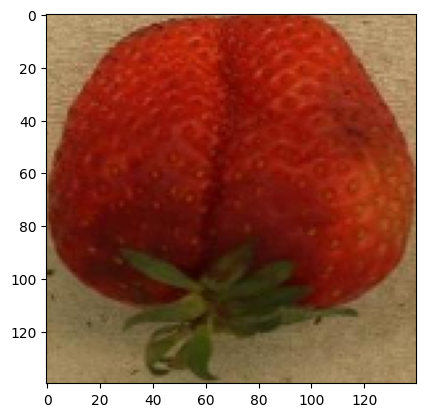

,ID,AverageMass,img
0,1,45.9258,"[[[118, 163, 190], [119, 164, 191], [119, 164,..."
1,2,45.9232,"[[[100, 144, 168], [102, 146, 170], [102, 146,..."
2,3,45.9206,"[[[98, 142, 166], [99, 143, 167], [99, 146, 16..."
3,4,45.9226,"[[[109, 152, 179], [108, 151, 178], [105, 148,..."
4,5,45.9219,"[[[119, 145, 159], [121, 148, 162], [118, 147,..."


In [18]:
#print(IDAndSquare)


croppedimages = pd.Series(IDAndSquare).to_frame().reset_index()
croppedimages.columns = ['ID', 'img']
croppedimages['ID'] = croppedimages['ID'].astype(int)

#croppedimages['img'] = croppedimages['img'].astype(float)


croppedimages = croppedimages.sort_values('ID')
croppedimages = croppedimages.reset_index(drop=True)

croppedimages.head(10)

#croppedimages.to_csv('croppedimagesBlueberriesRaw.csv', index = False)

###
%matplotlib inline 


crop = croppedimages.loc[50].at["img"][...,::-1]
#res = cv2.resize(crop, dsize=(140, 140), interpolation=cv2.INTER_CUBIC)


print(crop.shape)

plt.imshow(crop)
plt.show()
###


croppedimages = pd.merge(mass[['ID', 'AverageMass']], croppedimages[['ID', 'img']], on='ID', how='inner')

#croppedimages.to_csv('croppedimagesRaspberriesRaw.csv', index = False)

croppedimages.to_pickle('croppedimagesStrawberriesRaw.pkl')

croppedimages.head(5)

#print(latex_table)


# All data

In [63]:

allfeatures = pd.merge(classicgeometry[['ID', 'AverageMass', 'AreaInSquaredPixels', 'Roundness']], humoments[['ID', 'hu0', 'hu1', 'hu2', 'hu3', 'hu4', 'hu5', 'hu6']], on='ID', how='inner')
allfeatures = pd.merge(allfeatures[['ID', 'AverageMass', 'AreaInSquaredPixels', 'Roundness', 'hu0', 'hu1', 'hu2', 'hu3', 'hu4', 'hu5', 'hu6']], colors[['ID', 'meanB', 'meanG', 'meanR']], on='ID', how='inner')


allfeatures.to_csv('allfeaturesStrawberriesYOLO.csv', index = False)

allfeatures.head(5)

,ID,AverageMass,AreaInSquaredPixels,Roundness,hu0,hu1,hu2,hu3,hu4,hu5,hu6,meanB,meanG,meanR
0,1,45.9258,57872.5,0.4134,2.507102,5.654011,9.286607,9.286607,19.866419,13.606394,19.312481,17.410597,38.267586,122.445332
1,2,45.9232,57571.0,0.3869,2.463287,5.527105,9.441343,9.441343,18.691002,12.238727,19.433345,15.812079,34.770000,117.078969
2,3,45.9206,58238.0,0.3942,2.477350,5.566079,9.492894,9.492894,19.081489,12.632162,19.937082,16.678125,36.082346,119.858026
3,4,45.9226,57913.5,0.3717,2.468899,5.527758,9.629827,9.629827,18.157675,11.657153,18.720132,15.549159,35.049826,119.828651
4,5,45.9219,55933.5,0.4738,2.500461,5.637301,9.445823,9.445823,20.415947,-13.466744,-20.282669,16.806560,36.599756,123.610005
